<a href="https://colab.research.google.com/github/Ali-Alameer/Deep-Learning/blob/main/week9_YOLOv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Nov 21 13:33:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

fatal: destination path 'yolov9' already exists and is not an empty directory.
/content/yolov9


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow pyyaml

## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 804880
drwxr-xr-x 2 root root      4096 Nov 21 13:34 .
drwxr-xr-x 1 root root      4096 Nov 21 13:22 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt.1
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt.1
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt.1
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt.1


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [7]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

---



### gelan-c

In [9]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

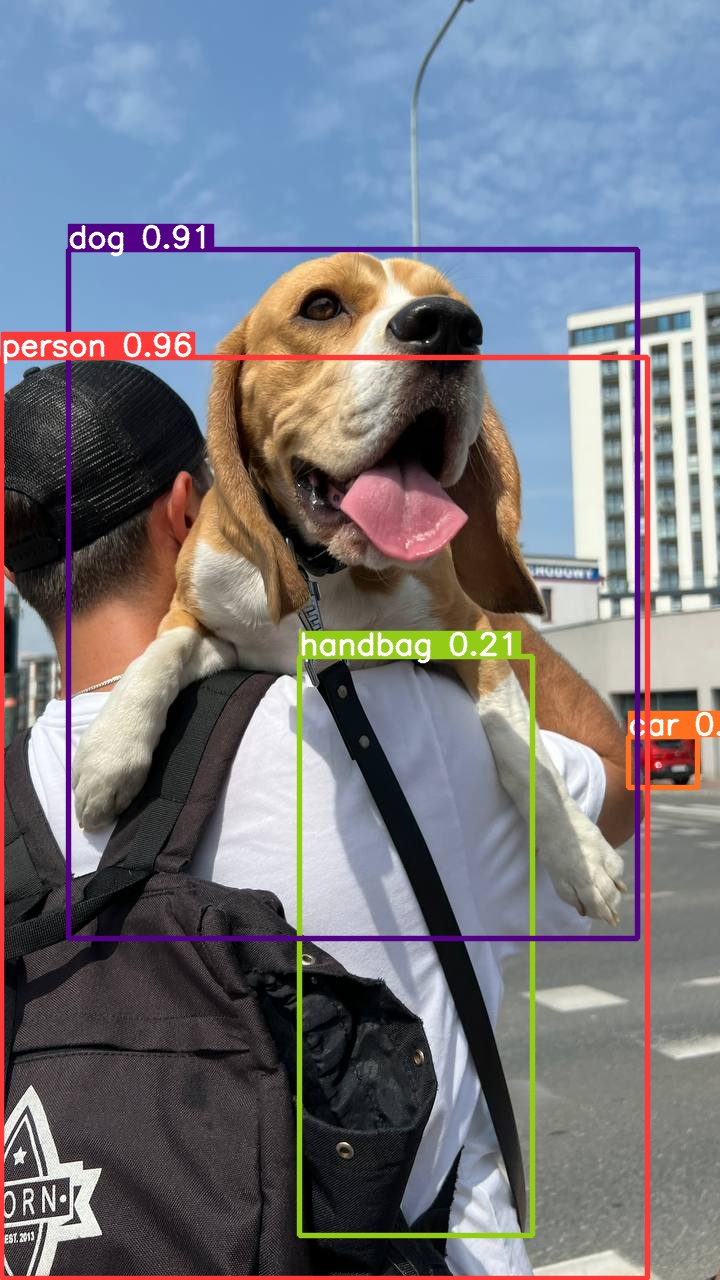

In [10]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [11]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only

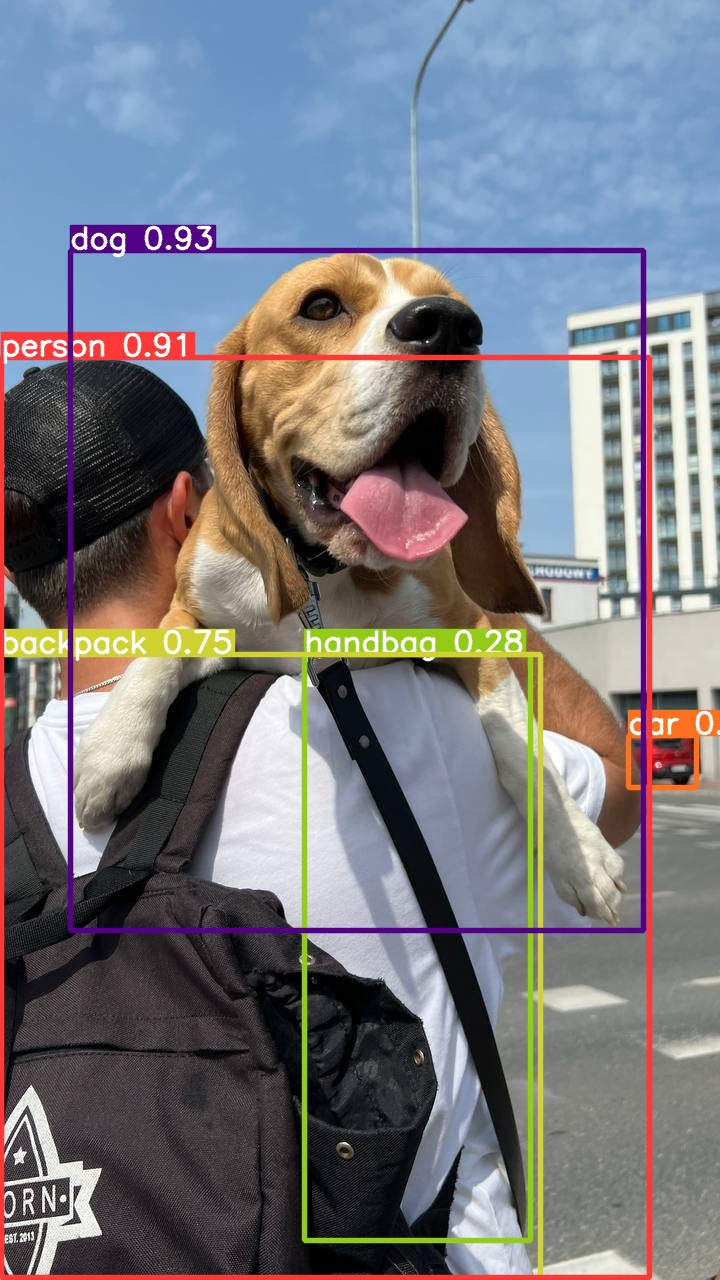

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [13]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [14]:
from roboflow import Roboflow
rf = Roboflow(api_key="mUHEgCsZL5CjyMMBo4zO")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(8)
dataset = version.download("yolov9")



# import roboflow

# roboflow.login()

# rf = roboflow.Roboflow()

# project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
# version = project.version(8)
# dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...


## Train Custom Model

In [15]:
dataset.location

'/content/yolov9/football-players-detection-8'

In [16]:
import yaml

# Step 1: Read the YAML file
input_file = f"{dataset.location}/data.yaml"
with open(input_file, 'r') as file:
    data = yaml.safe_load(file)
    print(data)

# Step 2: Add static paths
data["test"] = f"{dataset.location}/test/images"
data["train"] = f"{dataset.location}/train/images"
data["val"] = f"{dataset.location}/valid/images"

# Step 3.3: Write the updated content back to a YAML file
output_file = f"{dataset.location}/data-updated.yaml"
with open(output_file, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"Updated YAML saved to {output_file}")

{'names': ['ball', 'goalkeeper', 'player', 'referee'], 'nc': 4, 'roboflow': {'license': 'CC BY 4.0', 'project': 'football-players-detection-3zvbc', 'url': 'https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/8', 'version': 8, 'workspace': 'roboflow-jvuqo'}, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}
Updated YAML saved to /content/yolov9/football-players-detection-8/data-updated.yaml


In [17]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 2 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data-updated.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-11-21 13:34:42.324771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 13:34:42.344058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 13:34:42.350991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 13:34:42.366794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 13:34:43.706398: W

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [18]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    labels_correlogram.jpg  PR_curve.png  weights
events.out.tfevents.1732195609.f4598a11af81.1763.0  labels.jpg		    R_curve.png
F1_curve.png					    opt.yaml		    results.csv
hyp.yaml					    P_curve.png		    results.png


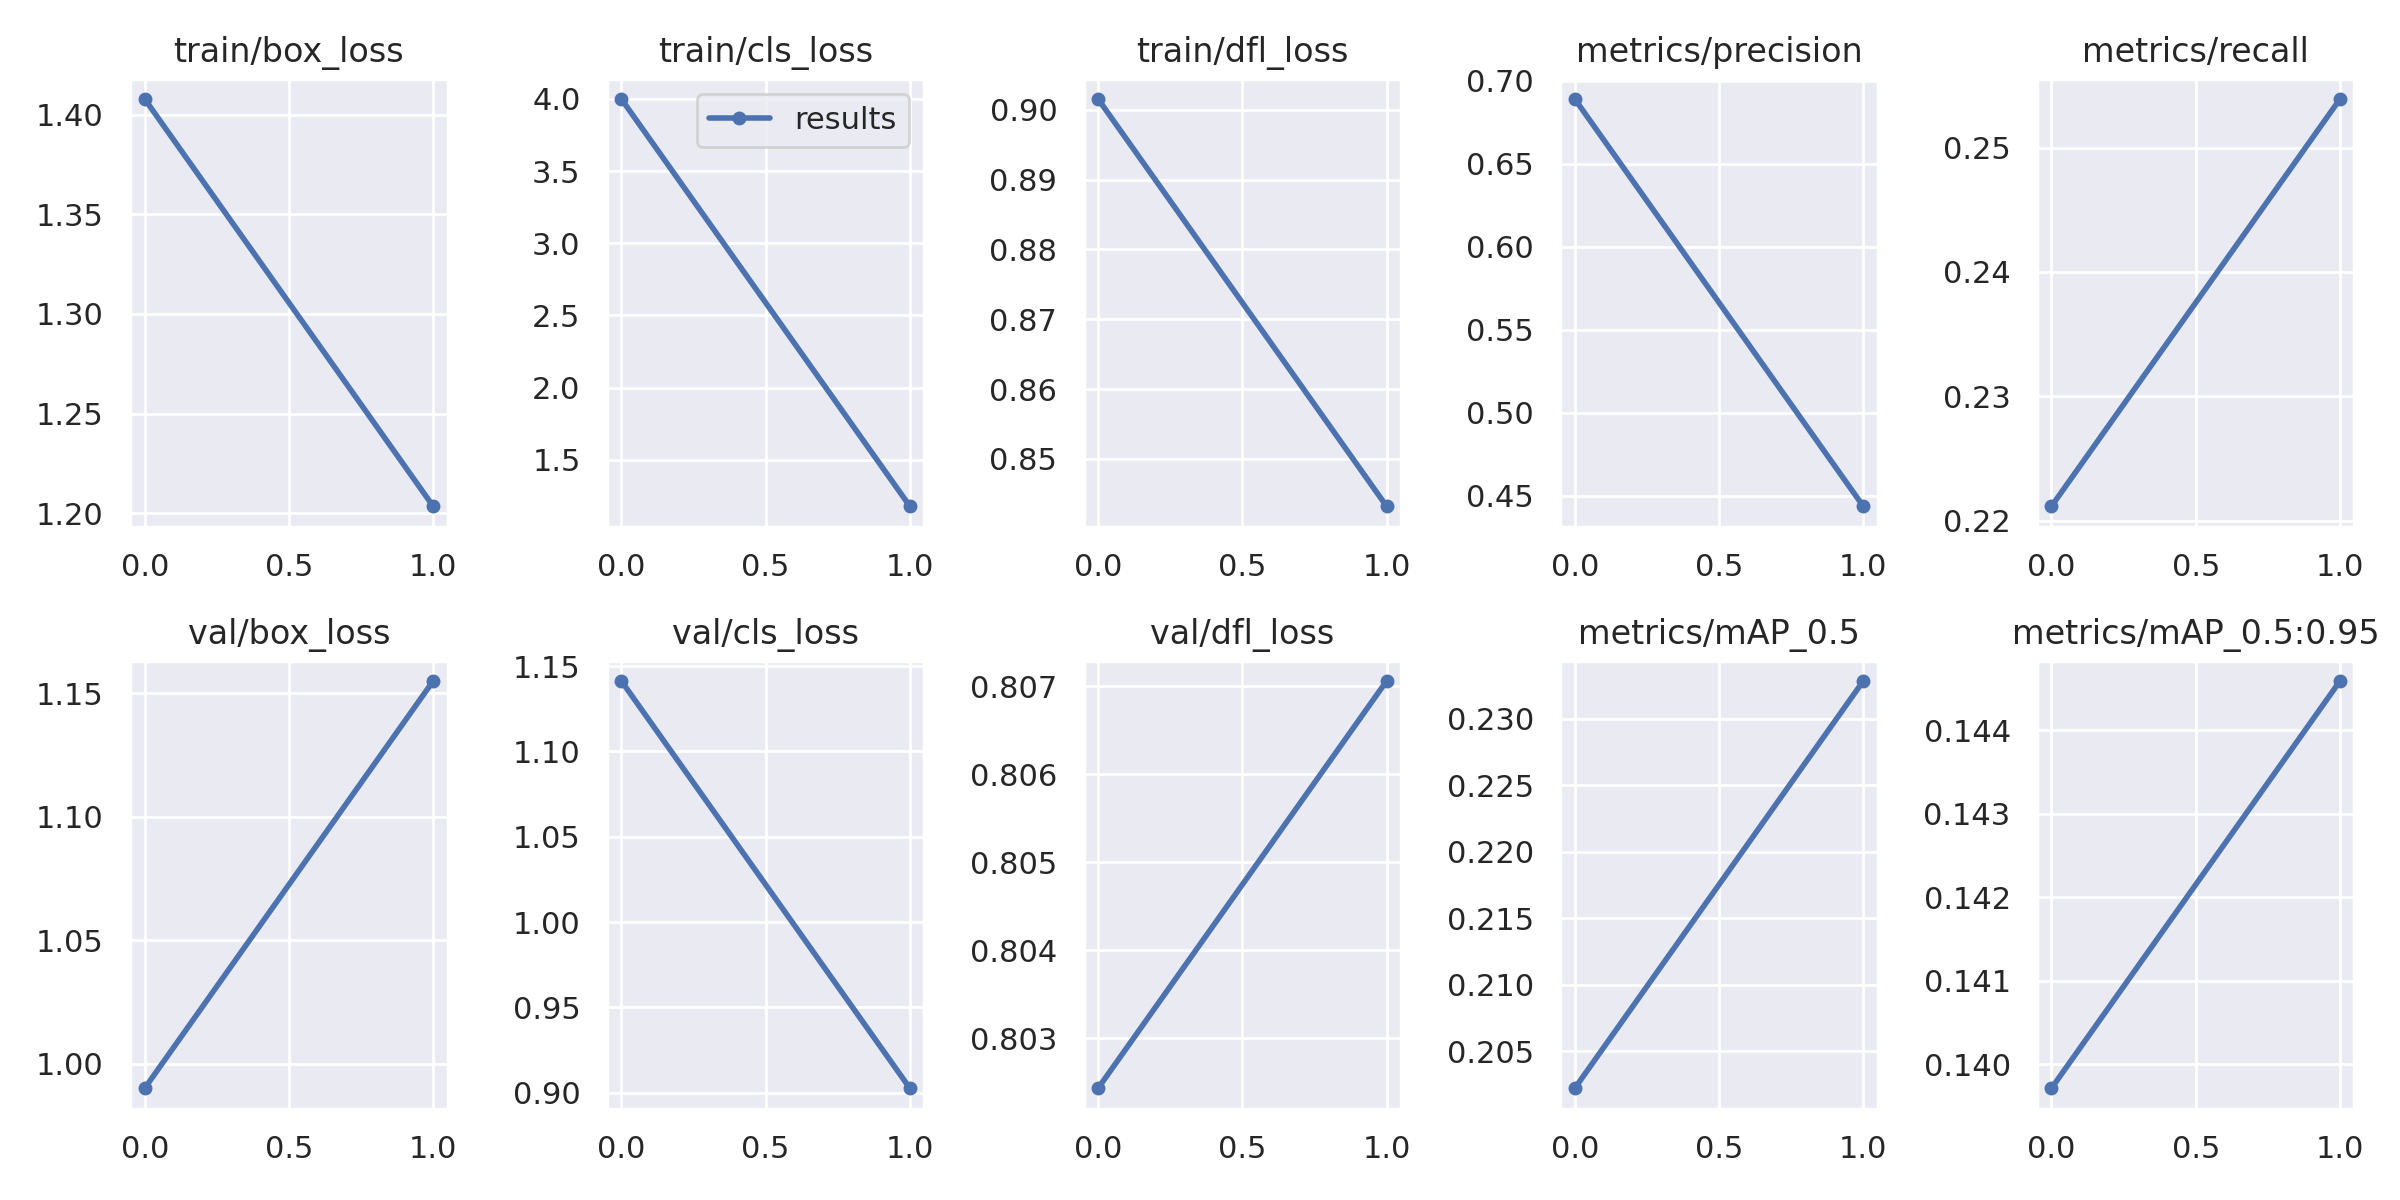

In [19]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

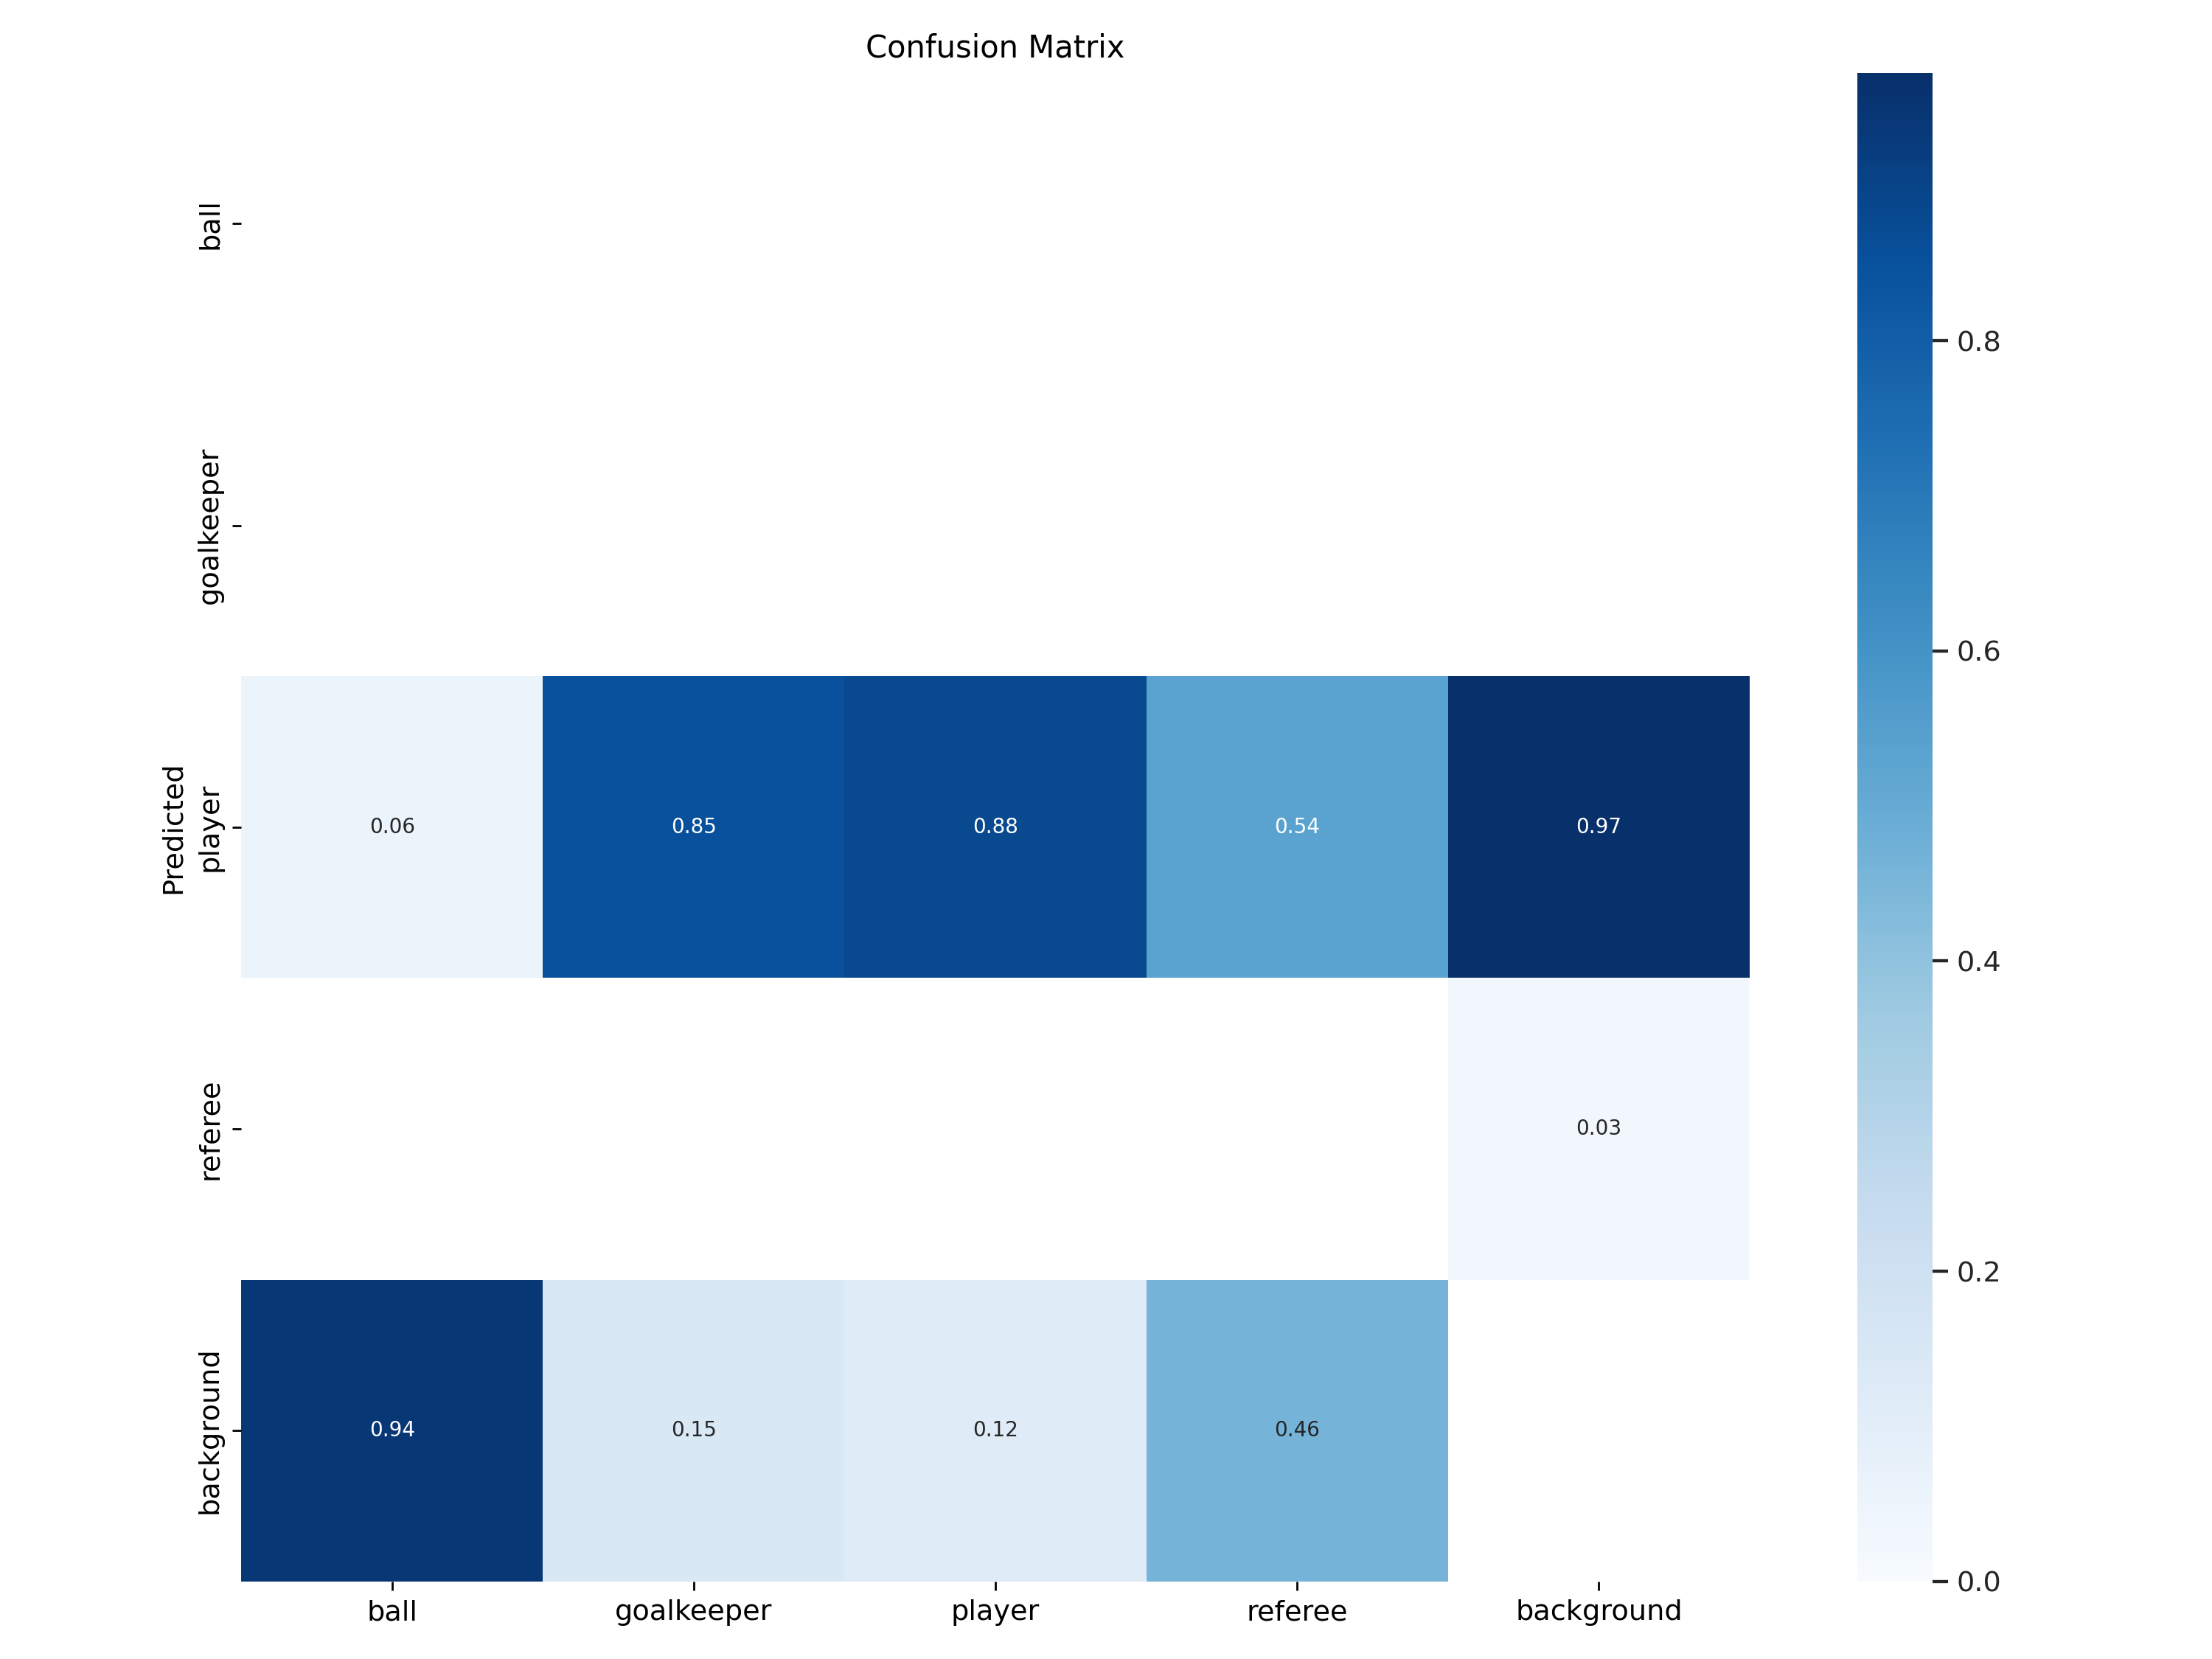

In [20]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

In [21]:
from IPython.display import Image

try:
  Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)
except:
  print("No images found")

No images found


## Validate Custom Model

In [22]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data-updated.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/football-players-detection-8/data-updated.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`

## Inference with Custom Model

In [23]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/football-players-detection-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

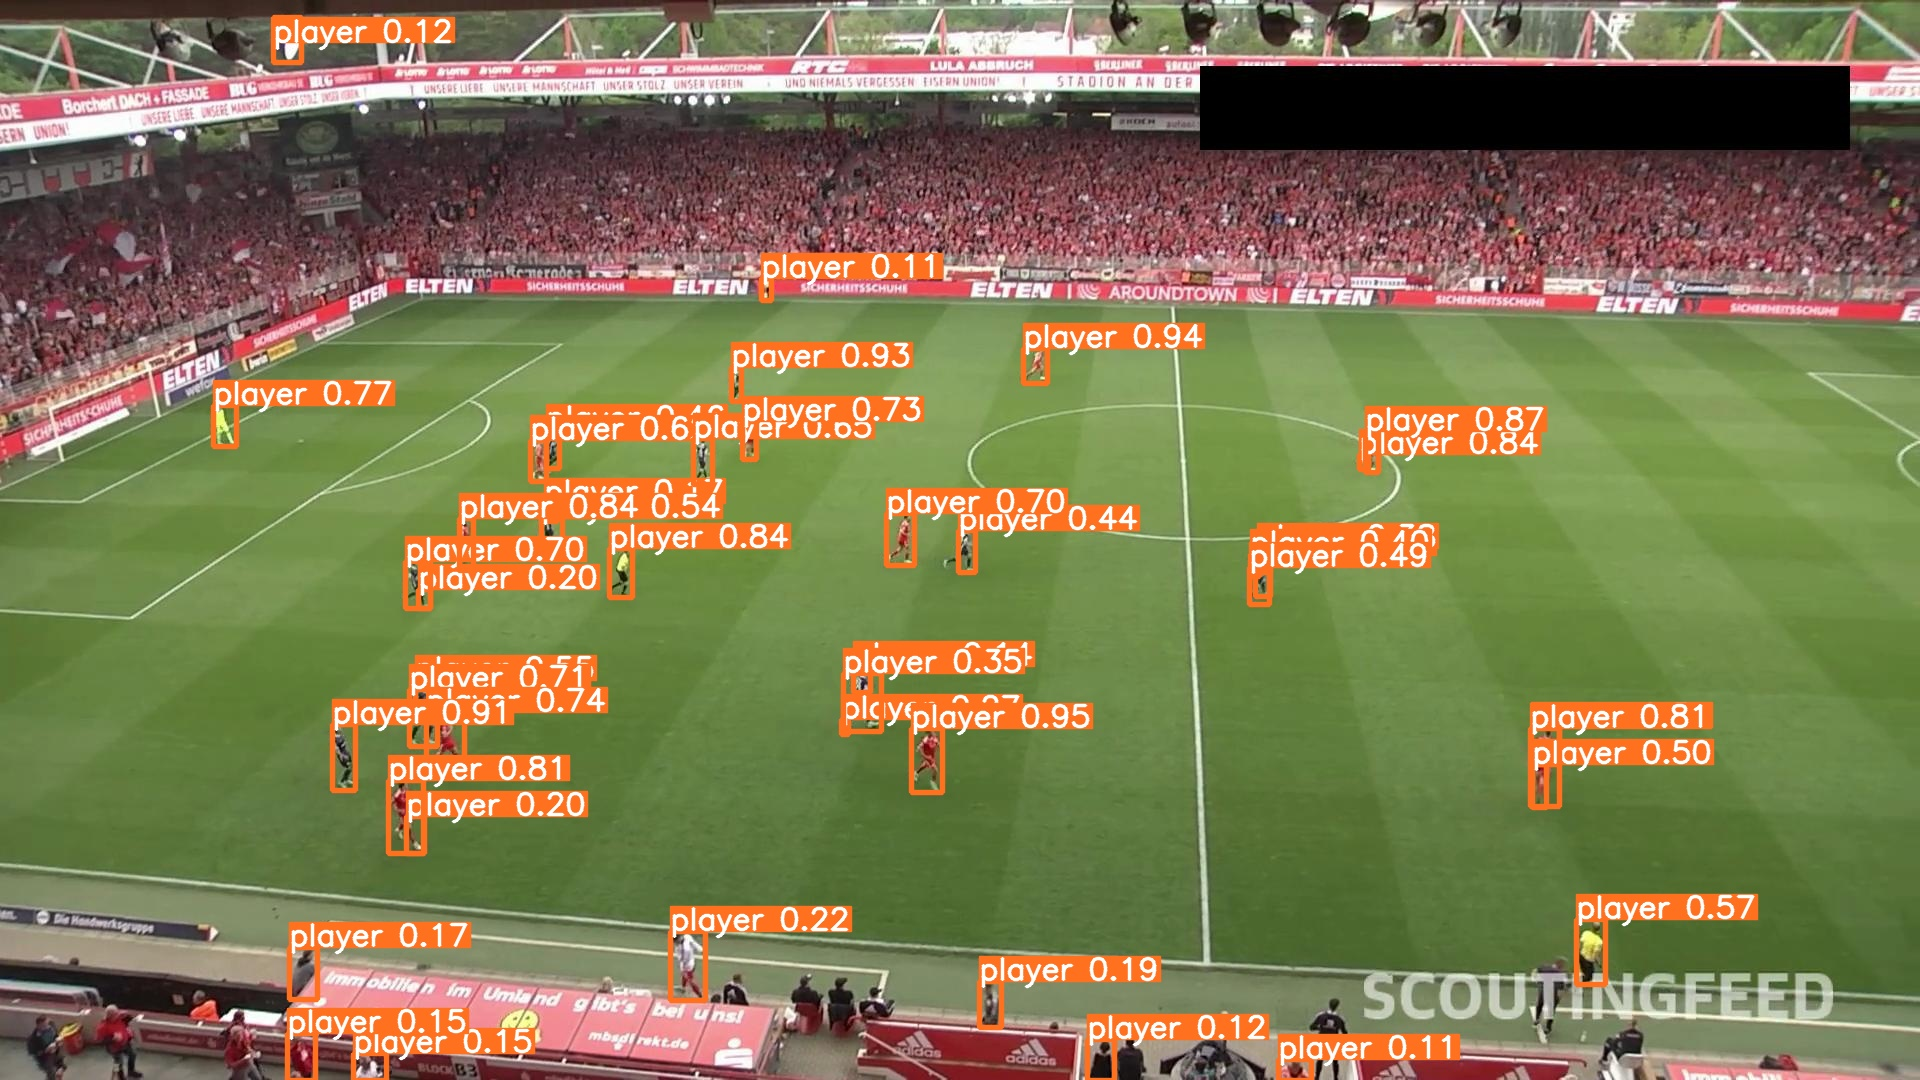

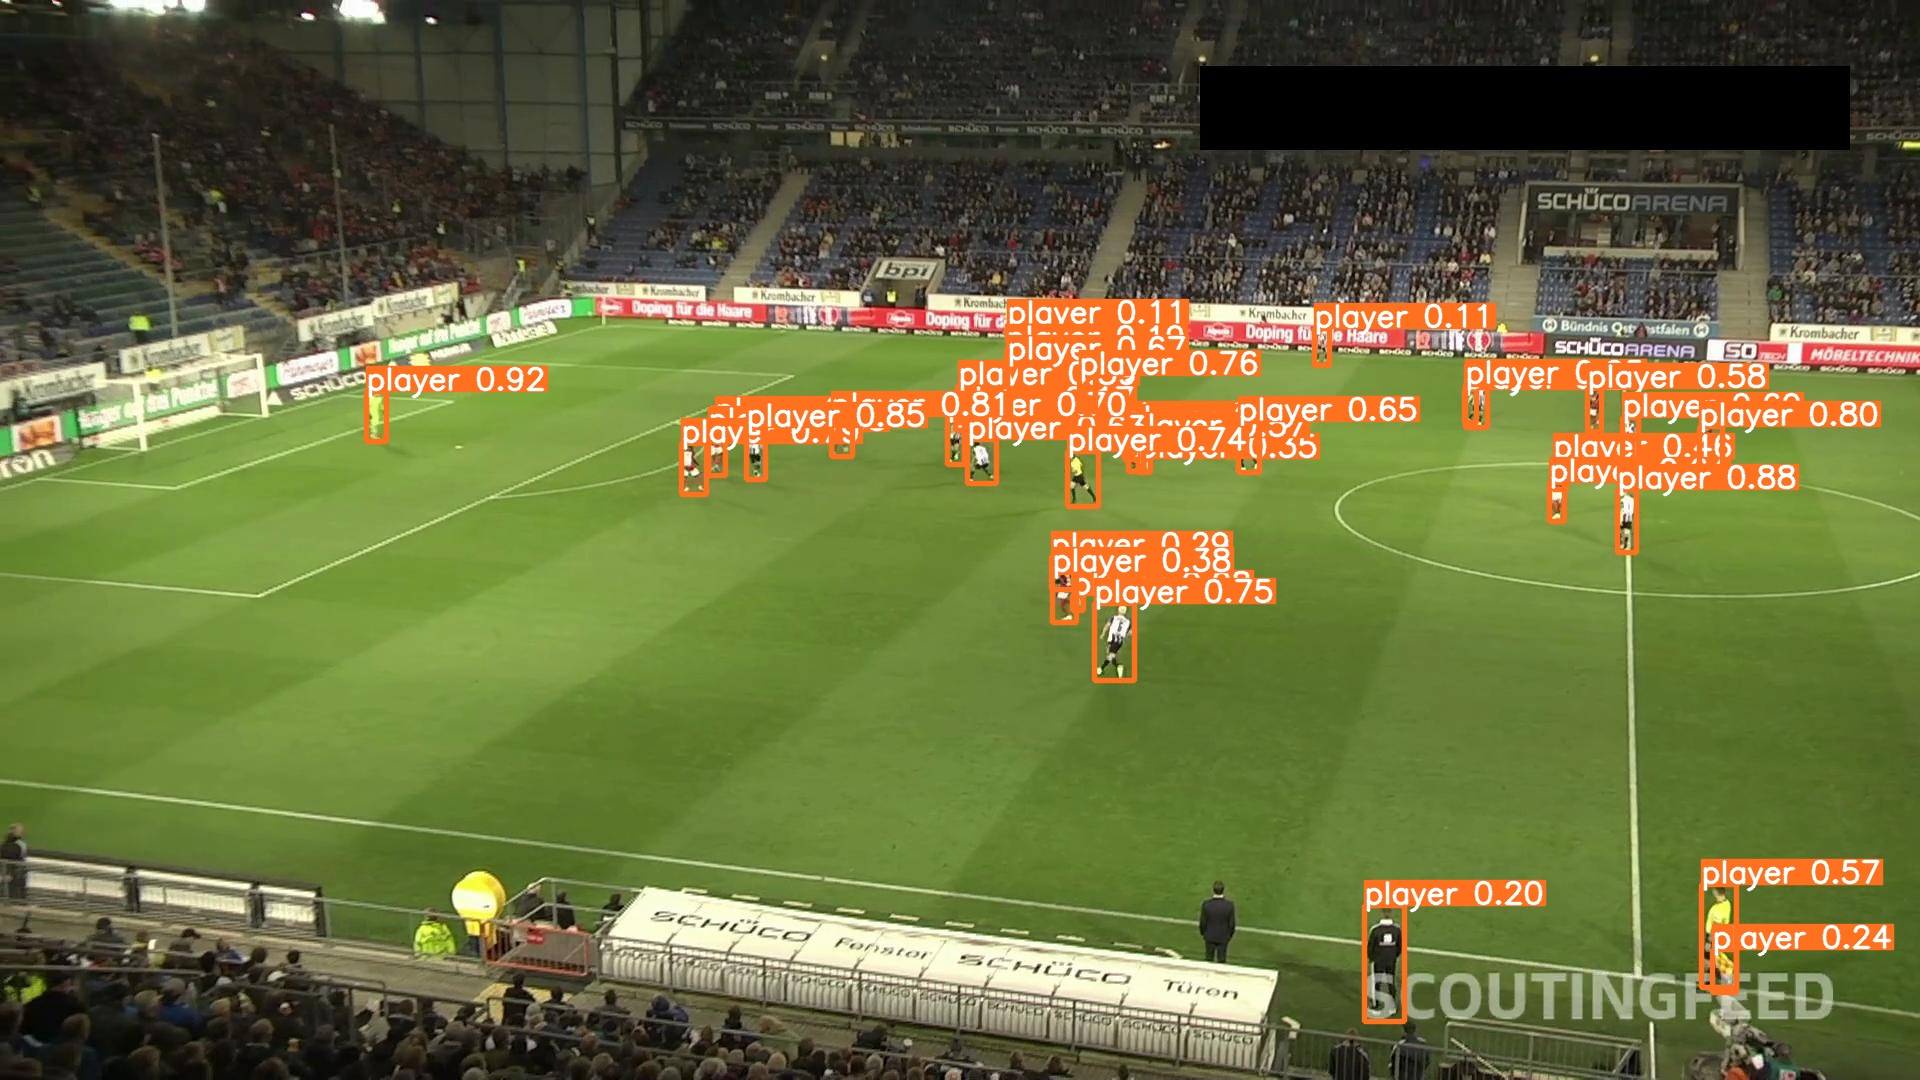

In [24]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))